In [64]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from einops import rearrange, repeat
from ome_types import from_xml, to_xml, OME
from ome_types.model import Image, Pixels, Channel

In [2]:
# ome tiff created in multiplex_imaging_analysis notebook
ome_path = Path('../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff')
assert ome_path.is_file()

## Reading in the OME-TIF

First we create a TiffFile object

In [3]:
tf = tifffile.TiffFile(ome_path)
tf

<tifffile.TiffFile '20240705_Human_B…ODEX_1.ome.tiff'>

### Reading metadata

We'll create a model of the ome tiff with the ome_types library.

It has all fields listed in the [OME-TIF specification ](https://www.openmicroscopy.org/Schemas/Documentation/Generated/OME-2016-06/ome.html)

In [4]:
ome = from_xml(tf.ome_metadata)
ome

OME(images=[<1 field_type>])

grabbing the actual image metadata

In [5]:
image = ome.images[0]
pixels = image.pixels
channels = pixels.channels

pixels

Pixels(
   id='Pixels:0',
   channels=[<38 field_type>],
   tiff_data_blocks=[{'plane_count': 38}],
   planes=[<38 field_type>],
   dimension_order='XYCZT',
   type='uint8',
   big_endian=False,
   size_x=19200,
   size_y=60480,
   size_z=1,
   size_c=38,
   size_t=1,
   physical_size_x=0.5100762527233116,
   physical_size_y=0.5100762527233116,
)

For here we'll list some common metadata fields

In [6]:
# resolution unit
pixels.physical_size_x_unit

<UnitsLength.MICROMETER: 'µm'>

In [7]:
# physical_size_x, physical_size_y - the image resolution in microns per pixel
pixels.physical_size_x, pixels.physical_size_y

(0.5100762527233116, 0.5100762527233116)

In [8]:
# size_x, size_y - the width and height of the image in pixels
pixels.size_x, pixels.size_y

(19200, 60480)

In [9]:
# size_c - number of channels (markers) in the image
pixels.size_c

38

In [10]:
# listing all channel names
names = [channel.name for channel in channels]
names

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

### Reading in pixel data

In [11]:
# to read in the actual pixel data for a specific channel, we can do the following
idx = names.index('Pan-Cytokeratin') # get index of the channel
x = tf.pages[idx].asarray()
x.shape # (height, width)

(60480, 19200)

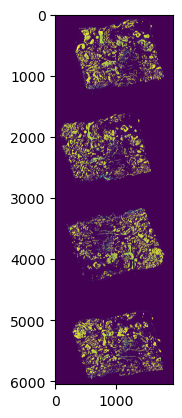

In [12]:
# lets show it, we can downsample the image so it displays faster
plt.imshow(x[::10, ::10])

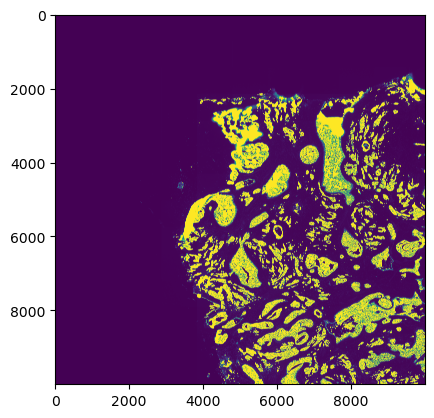

In [13]:
# we can also subset the image based on row and column pixel coordinates
small = x[:10000, :10000]
plt.imshow(small)

### Viewing images as pseudocolor

In [14]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

In [15]:
def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

We define which channels and how to display them in view_settings.

It is a list of dictionaries, each dictionary has the following keys
- channel - name of the channel
- color - hex string of the color to display channel as
- min_value - all pixel intensities below this value will be set to this value, range of the image values is usually 0-255
- max_value - all pixel intensities above this value will be set to this value, range of the image values is usually 0-255
- gamma - gamma contrast value


In [21]:
view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DR',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

to_view = [x['channel'] for x in view_settings]
data = np.stack([
    tf.pages[names.index(name)].asarray()
    for name in to_view
])

# note you can also do something like below to downsample the image so things run faster, but you will have a lower-res image
# downsampling here by factor of 10 just so the conversion runs faster for the example
# don't run this line if you want to do a pseudocolor that is the same size of the actual image

# data = data[..., ::10, ::10]

data.shape # (channels, height, width)

(3, 60480, 19200)

In [22]:
rgb = to_pseudocolor(data, view_settings)
rgb.shape # (height, width, rgb)

(60480, 19200, 3)

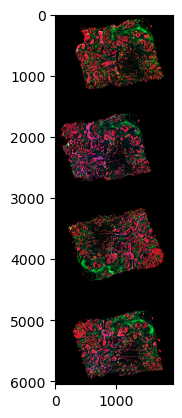

In [24]:
plt.imshow(rgb[::10, ::10])

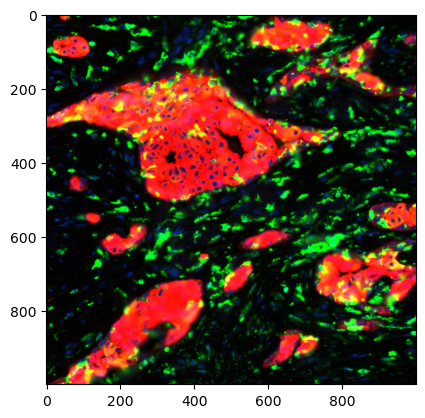

In [25]:
plt.imshow(rgb[10000:11000, 10000:11000])

## Masking out image regions and saving OME-TIFs

Here I show how to mask out parts of an image.

You could do this for any reason and any mask, but for now I'll demonstrate this capability by masking out specific cells in an image.

To do so I'll use the segmentation mask generated in [this notebook](https://github.com/estorrs/ding-lab-spatial/blob/main/multiplex_imaging/multiplex_imaging_analysis.ipynb)

In [20]:
seg_path = Path('../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1_cell_segmentation.tif')
labeled_img = tifffile.imread(seg_path)
labeled_img.shape

(60480, 19200)

Each pixel in the labeled image carries the integer label for a given pixel that maps it to a given cell. (0 is background)

In [31]:
# focusing on a small region so it runs fast
r1, r2, c1, c2 = 10000, 11000, 10000, 11000

rgb_small = rgb[r1:r2, c1:c2]
labeled_small = labeled_img[r1:r2, c1:c2]

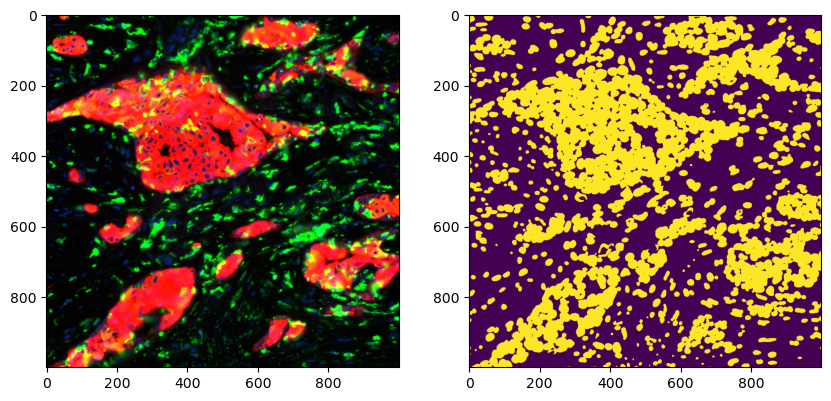

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].imshow(rgb_small)

axs[1].imshow(labeled_small > 0)

Randomly going to select some cells to mask

In [33]:
idxs = np.random.choice(np.unique(labeled_small), 1000)
idxs[:5]

array([150422, 164520, 164714, 163363, 162733], dtype=int64)

Creating pixel mask

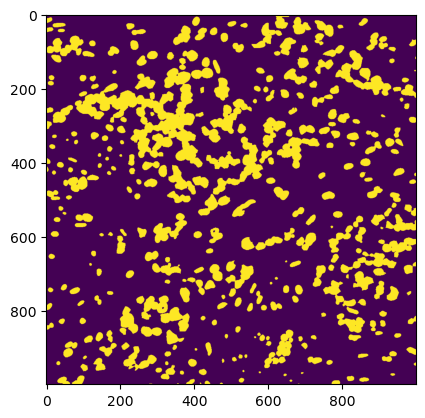

In [37]:
mask = np.isin(labeled_small, idxs)

plt.imshow(mask)

We can now use this mask to mask whatever we want

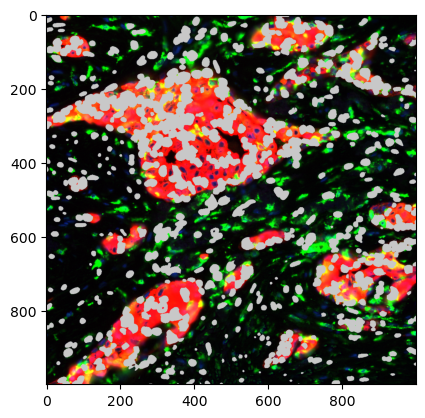

In [39]:
# like the rgb

new_rgb = rgb_small.copy()
new_rgb[mask] = [200, 200, 200] # replacing with gray

plt.imshow(new_rgb)

We could also save a new OME-TIF for viewing on other platforms like QuPath or omero

In [54]:
def write_ome_tif(output_fp, data, channel_names, mpp, subresolutions=4):
    """
    Writes a pyramidal OME-TIF.

    We can use this function to save multiplex images we have manipulated and want to resave.

    output_fp - where to write the ome-tif
    data - pixel data, should be (c, h, w)
    ome_model - OME model, should be created with ome-types
    subresolution - number of pyramid resolutions to write
    """
    assert len(channel_names) == data.shape[0]
    # creating OME model
    ome_model = OME(
        images=[
            Image(
                pixels=Pixels(
                    dimension_order='XYCZT',
                    type='uint8',
                    physical_size_x_unit='µm',
                    physical_size_y_unit='µm',
                    physical_size_x=mpp,
                    physical_size_y=mpp,
                    size_c=len(channel_names),
                    size_t=1,
                    size_x=data.shape[-1],
                    size_y=data.shape[-2],
                    size_z=1,
                    
                    channels=[
                        Channel(name=name) for name in channel_names
                    ]
                )
            )
        ]
    )
    
    with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
        opts = {
            'compression': 'LZW',
        }
        out_tif.write(
            data,
            subifds=subresolutions,
            **opts
        )
        for level in range(subresolutions):
            mag = 2**(level + 1)
            out_tif.write(
                data[:, ::mag, ::mag],
                subfiletype=1,
                **opts
            )
        xml_str = to_xml(ome_model)
        out_tif.overwrite_description(xml_str.encode())

First we need to grab all the channels from the image.

Since this is a demo we also segment out r1:r2, c1:c2, but you wouldn't do that for the full size image.

In [46]:
data_small = np.stack([
    tf.pages[i].asarray()[r1:r2, c1:c2]
    for i in range(len(names))
])

data_small.shape

(38, 1000, 1000)

Here we add another channel to the image that represent our mask. But you could also zero out the exissting image data, etc.. Whatever suits your purposes

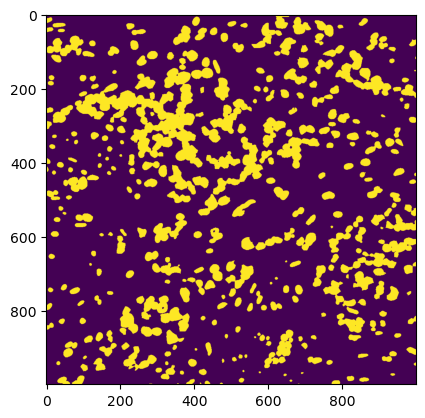

In [48]:
x = np.zeros_like(mask, dtype=np.uint8)
x[mask] = 255 # setting to max value for uint8
plt.imshow(x)

In [49]:
# adding to the image data
data_small = np.concat((data_small, x[None, :, :]), 0)
data_small.shape

(39, 1000, 1000)

In [65]:
channel_names = [*names, 'mask'] # calling the new channel "mask"
mpp = pixels.physical_size_x # grabbing resolution of the image

output_path = '../data/20240705_Human_BRCA_HT704B1_CODEX_1/small_altered.ome.tiff'
write_ome_tif(output_path, data_small, channel_names, mpp, subresolutions=4)